In [1]:
import os, sys
sys.path.append("..")

In [2]:
from opttrot.pauli import from_pstr
from opttrot.pauli_frame import PauliFrame
from opttrot.hamiltonian import Hamiltonian
from opttrot.utils import _bitwise_count_c

from opttrot.graph_algs.graph_opts import DWave

In [3]:
import numpy as np
np.version.version
from matplotlib import pyplot as plt

# Test with IZ family Hamiltonian

In [4]:
# Random IZ Hamiltonian
qubits = 4
N = int(2**qubits)
H = np.diag(np.random.rand(N)).astype(complex)
#H[1,2] = 0.4
#H[2,1] = 0.4

In [5]:
hamiltonian = Hamiltonian(H)

In [6]:
a = hamiltonian.poly

In [7]:
a

array([PauliElement(n=4, weight=0.363317+(0.000000)j, IIII),
       PauliElement(n=4, weight=0.355763+(0.000000)j, IIIZ),
       PauliElement(n=4, weight=0.731922+(0.000000)j, IIZI),
       PauliElement(n=4, weight=0.628864+(0.000000)j, IIZZ),
       PauliElement(n=4, weight=0.661384+(0.000000)j, IZII),
       PauliElement(n=4, weight=0.871850+(0.000000)j, IZIZ),
       PauliElement(n=4, weight=0.141630+(0.000000)j, IZZI),
       PauliElement(n=4, weight=0.251915+(0.000000)j, IZZZ),
       PauliElement(n=4, weight=0.264819+(0.000000)j, ZIII),
       PauliElement(n=4, weight=0.048194+(0.000000)j, ZIIZ),
       PauliElement(n=4, weight=0.890546+(0.000000)j, ZIZI),
       PauliElement(n=4, weight=0.789091+(0.000000)j, ZIZZ),
       PauliElement(n=4, weight=0.823113+(0.000000)j, ZZII),
       PauliElement(n=4, weight=0.887045+(0.000000)j, ZZIZ),
       PauliElement(n=4, weight=0.141353+(0.000000)j, ZZZI),
       PauliElement(n=4, weight=0.694656+(0.000000)j, ZZZZ)], dtype=object)

In [8]:
st = [s for p, s in hamiltonian.terms]
st

['IIII',
 'IIIZ',
 'IIZI',
 'IIZZ',
 'IZII',
 'IZIZ',
 'IZZI',
 'IZZZ',
 'ZIII',
 'ZIIZ',
 'ZIZI',
 'ZIZZ',
 'ZZII',
 'ZZIZ',
 'ZZZI',
 'ZZZZ']

In [9]:
mat = hamiltonian.adj_mat

In [10]:
from dwave.cloud import Client
from dwave.system.samplers import DWaveCliqueSampler
import dwave_networkx as dnx

import rustworkx as rx
import networkx as nx

token = r"yXwP-57ffecb35c6d604ff99be7b49223982f60ea4b42"

In [11]:
client = Client(token= token)

In [12]:
sampler_cli = DWaveCliqueSampler(token= token)

In [13]:
g = hamiltonian.to_graph(networkx=True)

In [14]:
len(g)

16

In [15]:
dnx.maximum_clique(g,  sampler = sampler_cli)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [16]:
L = hamiltonian.get_commuting_group(solver = None)

In [17]:
len(L[0])

16

In [18]:
adj = rx.adjacency_matrix(hamiltonian.to_graph())
G = nx.from_numpy_array(adj)

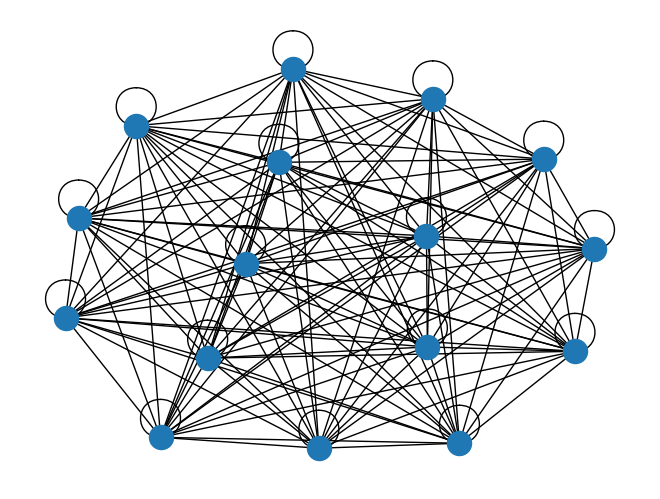

In [19]:
nx.draw(G)

In [20]:
sampler_cli = DWaveCliqueSampler(token= token)
clique = dnx.maximum_clique(G, sampler = sampler_cli)

In [21]:
dwave_solver = DWave(token=token)

In [22]:
hamiltonian.get_commuting_group(solver = dwave_solver)

Get a client:
Initiate the solver:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]

In [23]:
commuting_group = hamiltonian.get_commuting_group()

In [24]:
[st.index(c) for c in commuting_group[0]], [st.index(c) for c in commuting_group[1]]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [])

In [25]:
pf = PauliFrame(qubits)
pf

1, IIIZ, IIIX
1, IIZI, IIXI
1, IZII, IXII
1, ZIII, XIII

In [26]:
Distance = {
    0: [],
    1: [],
    2: [],
    3: []
}
pf = PauliFrame(qubits)
for p in commuting_group[0]:
    L = pf.relative_supp(from_pstr(p, 1.0).sym_code) -1
    if L == -1:
        L = 0
    Distance[L].append(p)

print(Distance)


{0: ['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'], 1: ['IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'], 2: ['IZZZ', 'ZIZZ', 'ZZIZ', 'ZZZI'], 3: ['ZZZZ']}


In [27]:
pf.relative_supp(from_pstr("ZZIZ", 1.0).sym_code, count="front")

0

In [28]:
pf.relative_supp(from_pstr("ZZIZ", 1.0).sym_code, count="front")

0

Modified Ultra Greedy Search

```
Algorithm 1 PFG Ultra-greedy Search 

Input: List of Hamiltonian terms and angles H = {(θα, pα)} 
Return: List of circuit elements Creturn 
1: Creturn ← {} i.e. is an empty circuit. 
2: ham ← {bin(pα)}. 
3: while ham ̸= ∅ do 
4:      minsup ← N 
5:      hammin = {} 
6:      cost = 1.1 
7:      gmin ← I 
8:      for p ∈ ham do 
9:         if Supp(p) =1 then 
10:            Add rotation to Creturn according to local support for 
               angle ±θα with sign given by sign of p. 
11:            Remove p from ham. 
12:        else if Supp(p) = minsup then 
13:            Add p to hammin 
14:        else if 2 ≤ Supp(p) < minsup then 
15:            Clear hammin and add p 
16:            minsup ← Supp(p) 
17:        end if 
18:     end for 
19:     for p ∈ hammin do 
20:         for all gates g which reduces support of p do 
21:             if costc(g) < cost then 
22:                 gmin ← g. 
23:                 cost ← costc(g) 
24:             end if 
25:         end for 
26:     end for 
27:     Add gmin to Creturn. 
28:     Update all members of ham using the TQE transformation rules for gmin. 
29: end while
```

## Circuit generation

In [29]:
import opttrot

In [30]:
import importlib
importlib.reload(opttrot)

<module 'opttrot' from 'c:\\Users\\cmat411a\\Documents\\GitHub\\Org_OptTrot\\OptTrot\\test\\..\\opttrot\\__init__.py'>

In [31]:
from opttrot.pauli_frame import PauliFrame

In [169]:
from opttrot.pauli_utils import pstr2sym_code
def int2bin(i, width):
    return np.array(list(np.binary_repr(i, width=width)), dtype=int)
from scipy.linalg import lu
def ul(M):
    Q = np.flip(np.eye(*M.shape), axis=0)
    P, L, U = lu(Q@M@Q)
    return Q@P@Q, Q@L@Q, Q@U@Q


In [170]:
Distance

{0: ['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
 1: ['IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
 2: ['IZZZ', 'ZIZZ', 'ZZIZ', 'ZZZI'],
 3: ['ZZZZ']}

In [171]:
Distance = {
    0: [],
    1: [],
    2: [],
    3: []
}
pf = PauliFrame(qubits)
for p in commuting_group[0]:
    L = pf.relative_supp(from_pstr(p, 1.0).sym_code) -1
    if L == -1:
        L = 0
    Distance[L].append(p)

print(Distance)


{0: ['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'], 1: ['IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'], 2: ['IZZZ', 'ZIZZ', 'ZZIZ', 'ZZZI'], 3: ['ZZZZ']}


In [172]:
qubits # System qubits

4

In [173]:
pf = PauliFrame(qubits)
paulis = commuting_group[0]
paulis_set = set(paulis)

In [174]:
circuit = [] # (gate name, arg, i, j, ...)
#while len(paulis) >0:
distance = {
    0: [],
    1: [],
    2: [],
    3: []
}
print("Calculate relative supports")
for p in paulis:
    L = pf.relative_supp(from_pstr(p, 1.0).sym_code) -1
    if L == -1:
        L = 0
    distance[L].append(p)
print("Applying current frame elements")
for p in distance[0]:
    if p == qubits*"I":
        continue
    i = np.where(pf.front[:, 1] == pstr2sym_code(p)[1])[0][0]
    circuit.append(("rz", 0., i))
    paulis_set.remove(p)
# construct a new frame to rotate
print("Construct a new frame from the remained terms")
p_frame = []
if len(distance[1]) == qubits:
    p_frame = distance[1]
else:
    p_frame = p_frame + distance[1][:qubits]
    while len(p_frame) < qubits:
        for k in range(2, qubits):
            l = qubits - len(p_frame)
            if qubits - len(p_frame) >= len(distance[k]):
                p_frame = p_frame + distance[k]
            else:
                p_frame = p_frame + distance[k][:l]
print(p_frame)


Calculate relative supports
Applying current frame elements
Construct a new frame from the remained terms
['IIZZ', 'IZIZ', 'IZZI', 'ZIIZ']


In [175]:
# Transform the frames into augmatrix
Mx, Mz = pf.aug_matrices_front
X = []
for p in p_frame:
    nx, nz = pstr2sym_code(p)
    v = int2bin(nz, width=qubits)
    x = np.linalg.solve(Mz, v)
    X.append(x)
X = np.flip(np.vstack(X), axis=0).T
X = X.astype(int)%2
print("Combination calculation")
print(X)

Combination calculation
[[1 0 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [1 0 1 1]]


In [227]:
# Get CX map
p, l, u = lu(X)
P, U, L = ul(X)
p = p.astype(int)%2
l = l.astype(int)%2
u = u.astype(int)%2
P = P.astype(int)%2
U = U.astype(int)%2
L = L.astype(int)%2

# Get CX cost
lu_cost = np.sum(l) + np.sum(u) - 2*qubits
ul_cost = np.sum(U) + np.sum(L) - 2*qubits
print(lu_cost, ul_cost)
t_f, t_b = (l, u) if lu_cost <= ul_cost else (U, L)

np.fill_diagonal(t_f, 0) 
np.fill_diagonal(t_b, 0) 

4 6


In [228]:
p@l@u

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]], dtype=int32)

In [229]:
t_f, t_b

(array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 1, 0]], dtype=int32),
 array([[0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]], dtype=int32))

In [241]:
cx_map_f = np.vstack(np.nonzero(t_f)).T
cx_map_f.sort(axis=0)
cx_map_f = np.flip(cx_map_f, axis=0)

cx_map_b = np.vstack(np.nonzero(t_b)).T
cx_map_b.sort(axis=0)
cx_map_b = np.flip(cx_map_b, axis=0)

In [242]:
cx_map_f, cx_map_b

(array([[3, 2],
        [3, 1],
        [2, 0]], dtype=int64),
 array([[2, 3],
        [1, 2]], dtype=int64))

In [249]:
pf = PauliFrame(qubits)

In [250]:
pf.two_entangle(3, 2)
pf.two_entangle(3, 1)
pf.two_entangle(2, 0)


In [251]:
pf

1, ZZIZ, IIIX
1, ZIZI, IIXI
1, ZZII, IXIX
1, ZIII, XXXI

In [252]:
pf.two_entangle(2, 3)
pf.two_entangle(1, 2)

In [254]:
pf.two_entangle(0, 3)

In [255]:
pf

1, ZZIZ, XXXX
1, ZIZI, XIIX
1, IZZI, XIXX
1, ZIIZ, XXXI

In [ ]:
'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ'

In [180]:
for i in range(qubits): # Lower triangle
    loc = -(1+i)
    vec = l[-(1+i), :]
    print("vec", vec, i)
    
    for j in range(qubits-i-1):
        col_loc = -(j+1)-i
        #print(col_loc, i)
        k = l[loc-(j+1), :col_loc]
        _vec = vec[:col_loc]
        if np.array_equal(k, _vec):
            circuit.append(("cx", j, i))


vec [1 0 1 1] 0
vec [0 1 1 0] 1
vec [0 1 0 0] 2
vec [1 0 0 0] 3


In [181]:
u

array([[1, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 0]], dtype=int32)

In [183]:
for i in range(qubits): # Upper triangle
    loc = -(1+i)
    vec = u[i, :]

    for j in range(qubits-i-1):
        col_loc = (j+1)+i
        k = u[i+j+1, col_loc:]
        _vec = vec[col_loc:]
        if len(k) ==1 and k==0:
            continue
        if np.array_equal(k, _vec):
            circuit.append(("cx", j, i))

In [184]:
circuit

[('rz', 0.0, 0),
 ('rz', 0.0, 1),
 ('rz', 0.0, 2),
 ('rz', 0.0, 3),
 ('cx', 2, 0),
 ('cx', 0, 1)]

In [164]:
if k ==0:
    print("yes")

yes
